In [18]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%autoreload 2
from copy import deepcopy
from delase import DeLASE
from delase.metrics import mase
from hydra import compose, initialize
from matplotlib import font_manager
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import sys
from tqdm.auto import tqdm

sys.path.append('../..')
from data_utils import get_delase_results, get_delase_run_list, get_grid_search_results, get_grid_search_run_list, get_grid_search_window_ts, get_section_info, load_session_data, load_window_from_chunks

plt.style.use('/om2/user/eisenaj/code/UniversalUnconsciousness/sci_style.mplstyle')
font_path = "/om2/user/eisenaj/miniforge3/envs/communication-transformer/fonts/arial.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

In [3]:
with initialize(version_base="1.3", config_path="../../DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
# data_class = cfg.params.data_class
session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class)) if f.endswith('.mat')]
session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]

# session_list = [session_list[1]]
# session_list = [session_list[2]]
# session_list = ['SPOCK_Ketamine_20210712', 'PEDRI_Ketamine_20220106']
# session_list = ['PEDRI_Ketamine_20220106']
# session_list = ['PEDRI_Ketamine_20220203']
# session_list = ['PEDRI_Ketamine_20220113']

In [5]:
areas = ['vlPFC', 'dlPFC', '-R', '-L']

## PCA

In [6]:
if cfg.params.pca:
    pca_chosen = {}
    for session in session_list:
        section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
        
        print("-"*20)
        print(f"SESSION = {session}")
        print("-"*20)
    
        normed_folder = 'NOT_NORMED' if not cfg.params.normed else 'NORMED'
        filter_folder = f"[{cfg.params.high_pass},{cfg.params.low_pass}]" if cfg.params.low_pass is not None or cfg.params.high_pass is not None else 'NO_FILTER'
    
        pca_dir = os.path.join(cfg.params.grid_search_results_dir, cfg.params.data_class, "PCA_info", session, normed_folder, f"SUBSAMPLE_{cfg.params.subsample}", filter_folder, f"WINDOW_{cfg.params.window}")
        os.makedirs(pca_dir, exist_ok=True)
    
        pca_chosen[session] = {}
        for area in areas:
    
            # Get the relevant indices for each area
            os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
            variables = ['electrodeInfo']
            session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables, data_class=cfg.params.data_class, verbose=False)
            electrode_info = session_vars['electrodeInfo']
    
            if area == 'all':
                dimension_inds = np.arange(len(electrode_info['area']))
            else:
                # dimension_inds = np.where(electrode_info['area'] == area)[0]
                dimension_inds = np.where([area in area_entry for area_entry in electrode_info['area']])[0]
    
            # Get PCA explained variance ratios
            area_pca_file = os.path.join(pca_dir, area)
            if os.path.exists(area_pca_file):
                print(f"Found PCA info for {session}: {area}")
                pca_explained_variance_ratios = pd.read_pickle(area_pca_file)
            else:
                print(f"Computing PCA info for {session}: {area}")
                grid_search_window_start_ts = get_grid_search_window_ts(session, cfg.params.all_data_dir, cfg.params.data_class, section_info, cfg.params.num_windows_per_section, window_radius=30, random_state=cfg.params.random_state)
    
                directory = pd.read_pickle(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, f"{session}_lfp_chunked_20s", "directory"))
            
                pca_explained_variance_ratios = {}
                for t in tqdm(grid_search_window_start_ts, desc=f'Doing PCA for {session}: {area}'):
                    lfp = load_window_from_chunks(t, t + cfg.params.window, directory=directory, dimension_inds=dimension_inds)
                    lfp = lfp[::cfg.params.subsample]
                    # filter
                    pca = PCA(n_components=lfp.shape[1]).fit(lfp)
                    pca_explained_variance_ratios[t] = pca.explained_variance_ratio_
    
                pd.to_pickle(pca_explained_variance_ratios, area_pca_file)
    
            # pick the max number of PCs across windows greater than the threshold
            pca_chosen[session][area] = np.max([np.argmax(np.cumsum(evr) >= cfg.params.pca_thresh) for evr in pca_explained_variance_ratios.values()])
else:
    pca_chosen = None

# Collect Indices to Run

In [7]:
all_indices_to_run = {}
for session in session_list:
    print("-"*20)
    print(f"SESSION = {session}")
    print("-"*20)
    section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
    grid_search_window_start_ts = get_grid_search_window_ts(session, cfg.params.all_data_dir, cfg.params.data_class, section_info, cfg.params.num_windows_per_section, window_radius=30, random_state=cfg.params.random_state)
    normed_folder = 'NOT_NORMED' if not cfg.params.normed else 'NORMED'
    filter_folder = f"[{cfg.params.high_pass},{cfg.params.low_pass}]" if cfg.params.low_pass is not None or cfg.params.high_pass is not None else 'NO_FILTER'

    grid_search_run_list = get_grid_search_run_list(session, os.path.join(cfg.params.grid_search_results_dir, cfg.params.data_class), cfg.params.all_data_dir, cfg.params.window, cfg.grid_sets[cfg.params.grid_set], cfg.params.grid_set, grid_search_window_start_ts, cfg.params.T_pred, group_ranks=cfg.params.group_ranks, verbose=True, random_state=cfg.params.random_state)

    for area in areas:
        
        pca_folder = "NO_PCA" if not cfg.params.pca else f"PCA_{pca_chosen[session][area]}"
        save_dir = os.path.join(cfg.params.grid_search_results_dir, cfg.params.data_class, 'grid_search_results', session, normed_folder, f"SUBSAMPLE_{cfg.params.subsample}", filter_folder, f"WINDOW_{cfg.params.window}", cfg.params.grid_set, area, pca_folder)

        os.makedirs(save_dir, exist_ok=True)
        
        saved_files = os.listdir(save_dir)

        
        if not cfg.params.group_ranks:
            # filter runs for those with valid rank
            filtered_run_list = []
            for run_index, run_info in enumerate(grid_search_run_list[area]):
                if cfg.params.pca:
                    n_dims = pca_chosen[session][area]
                else:
                    n_dims = len(run_info['dimension_inds'])
                    if run_info['n_delays']*n_dims >= run_info['rank']:
                        run_info['run_index'] = run_index
                        filtered_run_list.append(run_info)
        else: # runs don't need to be filtered
            filtered_run_list = []
            for run_index, run_info in enumerate(grid_search_run_list[area]):
                run_info['run_index'] = run_index
                filtered_run_list.append(run_info)
        
        indices_to_run = []
        for run_info in filtered_run_list:
            filename = f"run_index-{run_info['run_index']}.pkl"
            if filename not in saved_files:
                indices_to_run.append(run_info['run_index'])
    
        if len(indices_to_run) == 0:
            print(f"*COMPLETE*: All results completed for {session} - {area}!!")
        elif len(indices_to_run) == len(filtered_run_list):
            print(f"NOT STARTED: no results completed for {session} - {area}. Adding all indices! ({len(indices_to_run)})")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run
        else:
            print(f"INCOMPLETE: {session} - {area} incomplete, adding indices {indices_to_run}")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run

--------------------
SESSION = SPOCK_Ketamine_20210802
--------------------
*COMPLETE*: All results completed for SPOCK_Ketamine_20210802 - vlPFC!!
*COMPLETE*: All results completed for SPOCK_Ketamine_20210802 - dlPFC!!
*COMPLETE*: All results completed for SPOCK_Ketamine_20210802 - -R!!
*COMPLETE*: All results completed for SPOCK_Ketamine_20210802 - -L!!
--------------------
SESSION = PEDRI_Ketamine_20220224
--------------------
*COMPLETE*: All results completed for PEDRI_Ketamine_20220224 - vlPFC!!
*COMPLETE*: All results completed for PEDRI_Ketamine_20220224 - dlPFC!!
*COMPLETE*: All results completed for PEDRI_Ketamine_20220224 - -R!!
*COMPLETE*: All results completed for PEDRI_Ketamine_20220224 - -L!!
--------------------
SESSION = PEDRI_Ketamine_20220228
--------------------
*COMPLETE*: All results completed for PEDRI_Ketamine_20220228 - vlPFC!!
*COMPLETE*: All results completed for PEDRI_Ketamine_20220228 - dlPFC!!
*COMPLETE*: All results completed for PEDRI_Ketamine_20220228 - 

# Running

In [8]:
os.chdir('/om2/user/eisenaj/code/UniversalUnconsciousness')
batch_size = 250

In [9]:
sessions_to_run = list(all_indices_to_run.keys())
# sessions_to_run = sessions_to_run[:4]

# iterator = tqdm(total=np.sum([len(all_indices_to_run[session]) for session in sessions_to_run]), desc='Hydra Multiprocessing - DSA on Neural Data')
iterator = tqdm(total=np.sum([np.sum([int(np.ceil(len(all_indices_to_run[session][area])/batch_size)) for area in all_indices_to_run[session].keys()]) for session in sessions_to_run]), desc='Hydra Multiprocessing - Grid Search on Neural Data')

for session in sessions_to_run:
    for area in all_indices_to_run[session].keys():
        print(f"Running indices for {session} - {area}")
        num_batches = int(np.ceil(len(all_indices_to_run[session][area])/batch_size))
        for batch_num in range(num_batches):
            batch_start = batch_num*batch_size
            batch_end = np.min([(batch_num + 1)*batch_size, len(all_indices_to_run[session][area])])
            print(f"running batch #{batch_num}")
            if cfg.params.pca:
                os.system(f"HYDRA_FULL_ERROR=1 python DeLASE_analysis/run_grid_search.py -m ++params.session={session} ++params.area={area} ++params.pca_dims={int(pca_chosen[session][area])} ++params.run_index={','.join([str(i) for i in all_indices_to_run[session][area][batch_start:batch_end]])}")
            else:
                os.system(f"HYDRA_FULL_ERROR=1 python DeLASE_analysis/run_grid_search.py -m ++params.session={session} ++params.area={area} ++params.run_index={','.join([str(i) for i in all_indices_to_run[session][area][batch_start:batch_end]])}")
            iterator.update()
iterator.close()

Hydra Multiprocessing - Grid Search on Neural Data: 0it [00:00, ?it/s]

# Collect Grid Search Results

In [10]:
cfg.params.stat_to_use = 'aic'

In [11]:
grid_search_results = get_grid_search_results(cfg, session_list, areas, len(section_info), pca_chosen)

In [12]:
session = session_list[-1]
area = areas[0]

In [13]:
# grid_mats = grid_search_results[session][area]['mats'][cfg.params.stat_to_use]
# norm = Normalize(vmin=grid_mats[~np.isnan(grid_mats)].min(), vmax=grid_mats[~np.isnan(grid_mats)].max())
# fig, axs = plt.subplots(4, 8, figsize=(20, 12))
# for i in range(32):
#     ind = int(i/8) + i%8
#     ax = axs[int(i/8)][i%8]
#     ax.imshow(grid_mats[i], aspect='auto', norm=norm)

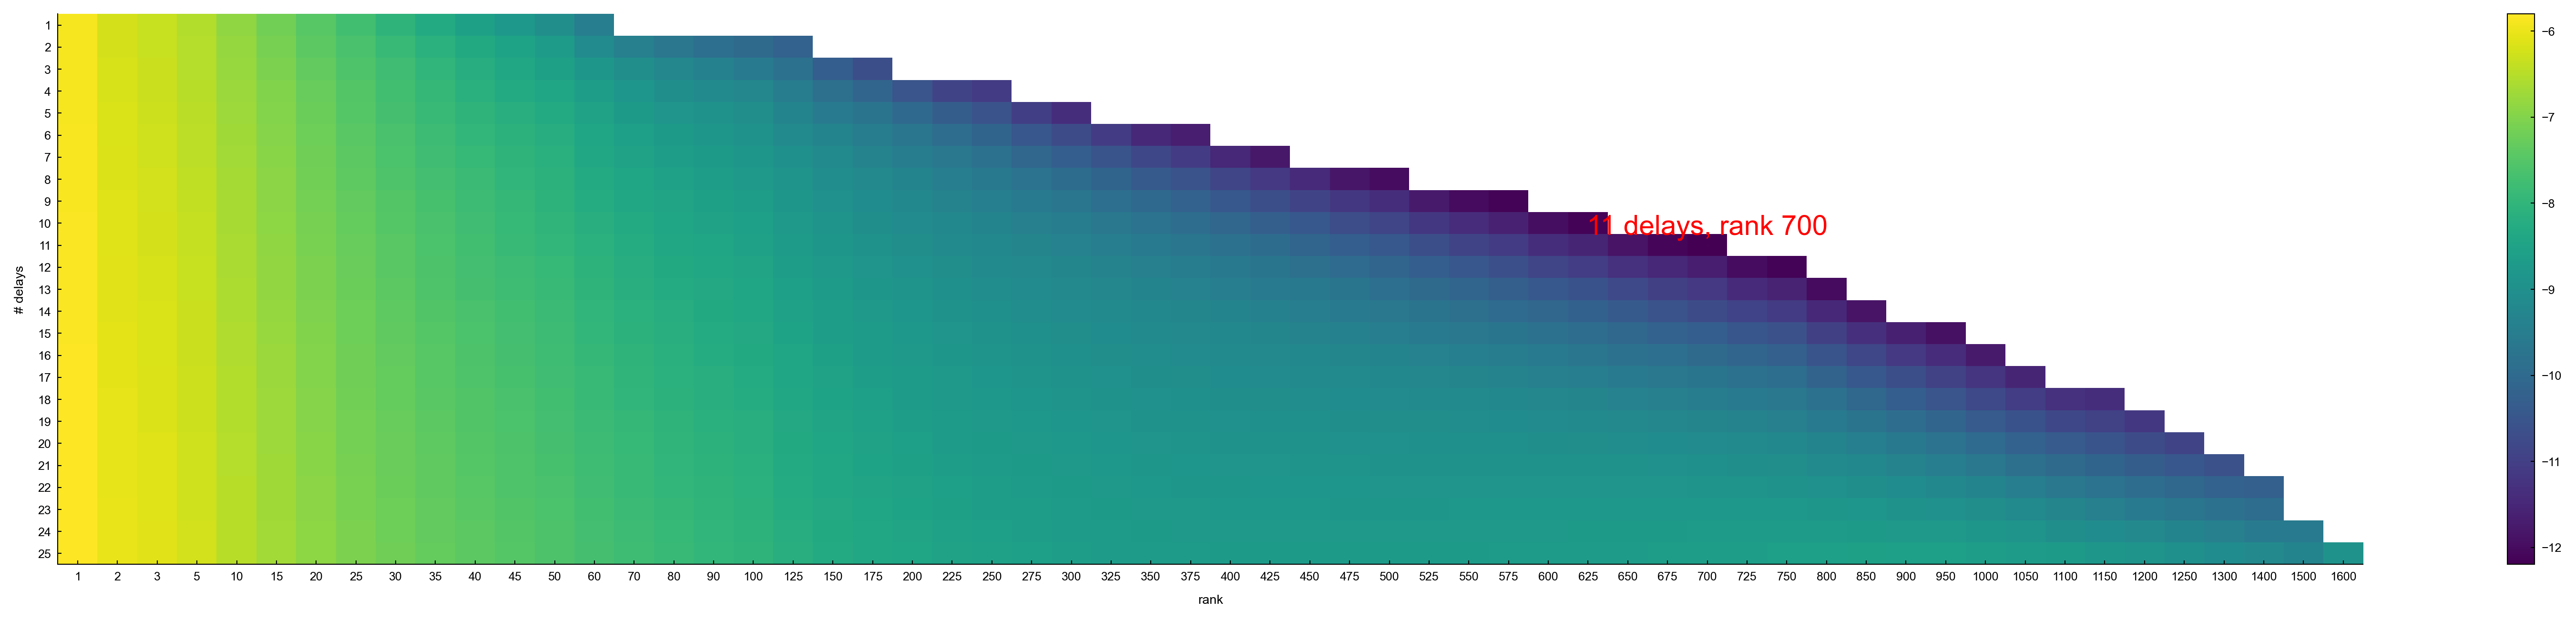

In [14]:
plt.figure(figsize=(26, 5))

n_ranks = np.argmax(np.isnan(grid_search_results[session][area]['mats'][cfg.params.stat_to_use][0, -1]))
results_to_show = deepcopy(grid_search_results[session][area]['mats'][cfg.params.stat_to_use][:, :, :n_ranks])
# results_to_show[results_to_show == 0] = np.nan

im = plt.imshow(results_to_show.mean(axis=0), aspect='auto')
i, j = grid_search_results[session][area]['i'], grid_search_results[session][area]['j']
plt.scatter(j, i, c='r')
n_delays = grid_search_results[session][area]['n_delays']
rank = grid_search_results[session][area]['rank']
plt.text(j, i - 0.5, f"{n_delays} delays, rank {rank}", c='r', ha='center', fontsize=14)
plt.xticks(np.arange(len(cfg.grid_sets[cfg.params.grid_set].rank_vals))[:n_ranks], cfg.grid_sets[cfg.params.grid_set].rank_vals[:n_ranks])
plt.yticks(np.arange(len(cfg.grid_sets[cfg.params.grid_set].n_delays_vals)), cfg.grid_sets[cfg.params.grid_set].n_delays_vals)
plt.ylabel('# delays')
plt.xlabel('rank')
plt.colorbar(im)
plt.show()

# Get DeLASE Run List

In [19]:
all_indices_to_run = {}
for session in session_list:
    print("-"*20)
    print(f"SESSION = {session}")
    print("-"*20)
    delase_run_list = get_delase_run_list(cfg, session)

    normed_folder = 'NOT_NORMED' if not cfg.params.normed else 'NORMED'
    filter_folder = f"[{cfg.params.high_pass},{cfg.params.low_pass}]" if cfg.params.low_pass is not None or cfg.params.high_pass is not None else 'NO_FILTER'
    
    for area in areas:
        pca_folder = "NO_PCA" if not cfg.params.pca else f"PCA_{pca_chosen[session][area]}"
        save_dir = os.path.join(cfg.params.delase_results_dir, cfg.params.data_class, 'delase_results', session, normed_folder, f"SUBSAMPLE_{cfg.params.subsample}", filter_folder, f"WINDOW_{cfg.params.window}", cfg.params.grid_set, f"STAT_TO_USE_{cfg.params.stat_to_use}", f"STRIDE_{cfg.params.stride}", area, pca_folder)

        os.makedirs(save_dir, exist_ok=True)
        
        saved_files = os.listdir(save_dir)
        indices_to_run = []
        for run_index in range(len(delase_run_list[area])):
            filename = f"run_index-{run_index}.pkl"
            if filename not in saved_files:
                indices_to_run.append(run_index)
        
        if len(indices_to_run) == 0:
            print(f"*COMPLETE*: All results completed for {session} - {area}!!")
        elif len(indices_to_run) == len(delase_run_list[area]):
            print(f"NOT STARTED: no results completed for {session} - {area}. Adding all indices! ({len(indices_to_run)})")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run
        else:
            print(f"INCOMPLETE: {session} - {area} incomplete, adding indices {indices_to_run}")
            if session not in all_indices_to_run:
                all_indices_to_run[session] = {}
            all_indices_to_run[session][area] = indices_to_run

--------------------
SESSION = SPOCK_Ketamine_20210802
--------------------
*COMPLETE*: All results completed for SPOCK_Ketamine_20210802 - vlPFC!!
*COMPLETE*: All results completed for SPOCK_Ketamine_20210802 - dlPFC!!
*COMPLETE*: All results completed for SPOCK_Ketamine_20210802 - -R!!
*COMPLETE*: All results completed for SPOCK_Ketamine_20210802 - -L!!
--------------------
SESSION = PEDRI_Ketamine_20220224
--------------------
*COMPLETE*: All results completed for PEDRI_Ketamine_20220224 - vlPFC!!
*COMPLETE*: All results completed for PEDRI_Ketamine_20220224 - dlPFC!!
*COMPLETE*: All results completed for PEDRI_Ketamine_20220224 - -R!!
*COMPLETE*: All results completed for PEDRI_Ketamine_20220224 - -L!!
--------------------
SESSION = PEDRI_Ketamine_20220228
--------------------
*COMPLETE*: All results completed for PEDRI_Ketamine_20220228 - vlPFC!!
*COMPLETE*: All results completed for PEDRI_Ketamine_20220228 - dlPFC!!
*COMPLETE*: All results completed for PEDRI_Ketamine_20220228 - 

### Run

In [20]:
os.chdir('/om2/user/eisenaj/code/UniversalUnconsciousness')
batch_size = 250

In [21]:
sessions_to_run = list(all_indices_to_run.keys())
# sessions_to_run = sessions_to_run[:4]

# iterator = tqdm(total=np.sum([len(all_indices_to_run[session]) for session in sessions_to_run]), desc='Hydra Multiprocessing - DSA on Neural Data')
iterator = tqdm(total=np.sum([np.sum([int(np.ceil(len(all_indices_to_run[session][area])/batch_size)) for area in all_indices_to_run[session].keys()]) for session in sessions_to_run]), desc='Hydra Multiprocessing - Grid Search on Neural Data')

for session in sessions_to_run:
    for area in all_indices_to_run[session].keys():
        print(f"Running indices for {session} - {area}")
        num_batches = int(np.ceil(len(all_indices_to_run[session][area])/batch_size))
        for batch_num in range(num_batches):
            batch_start = batch_num*batch_size
            batch_end = np.min([(batch_num + 1)*batch_size, len(all_indices_to_run[session][area])])
            print(f"running batch #{batch_num}")
            if cfg.params.pca:
                os.system(f"HYDRA_FULL_ERROR=1 python DeLASE_analysis/run_delase.py -m ++params.session={session} ++params.area={area} ++params.pca_dims={int(pca_chosen[session][area])} ++params.n_delays={int(grid_search_results[session][area]['n_delays'])} ++params.rank={int(grid_search_results[session][area]['rank'])} ++params.run_index={','.join([str(i) for i in all_indices_to_run[session][area][batch_start:batch_end]])}")
            else:
                os.system(f"HYDRA_FULL_ERROR=1 python DeLASE_analysis/run_delase.py -m ++params.session={session} ++params.area={area} ++params.n_delays={int(grid_search_results[session][area]['n_delays'])} ++params.rank={int(grid_search_results[session][area]['rank'])} ++params.run_index={','.join([str(i) for i in all_indices_to_run[session][area][batch_start:batch_end]])}")
            iterator.update()
iterator.close()

Hydra Multiprocessing - Grid Search on Neural Data: 0it [00:00, ?it/s]

# Collect DeLASE Results

In [22]:
delase_results = get_delase_results(cfg, session_list, areas, pca_chosen)

In [23]:
session_infos = {}
for session in tqdm(session_list):
    variables = ['sessionInfo']
    session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables, data_class=cfg.params.data_class, verbose=False)
    session_info = session_vars['sessionInfo']
    session_infos[session] = session_info

  0%|          | 0/30 [00:00<?, ?it/s]

In [24]:
session_lists = {'Spock': {}, 'Pedri': {}}
for session, session_info in session_infos.items():
    if 'SPOCK' in session:
        monkey = 'Spock'
    else:
        monkey = 'Pedri'
    
    if session_info['dose'] == 1.0:
        dose = 'low'
    else:
        dose = 'high'

    if dose in session_lists[monkey].keys():
        session_lists[monkey][dose].append(session)
    else:
        session_lists[monkey][dose] = [session]

In [25]:
dt_stab = 0.01
top_percent = 0.1

stability_all = {}
freqs_all = {}
counts = {}

total_its = 0
for monkey in session_lists.keys():
    for dose in session_lists[monkey].keys():
        for area in areas:
            leadup_time = min([session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
            post_time = min([delase_results[session][area].window_end.max() - session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
            for session_ind, session in enumerate(session_lists[monkey][dose]):
                filter_inds = np.logical_and(delase_results[session][area].window_start >= session_infos[session]['infusionStart'] - leadup_time*60, delase_results[session][area].window_end <= session_infos[session]['infusionStart'] + post_time*60)
                total_its += len(delase_results[session][area][filter_inds])
iterator = tqdm(total=total_its)

for monkey in session_lists.keys():
    stability_all[monkey] = {}
    freqs_all[monkey] = {}
    counts[monkey] = {}
    for dose in session_lists[monkey].keys():
        stability_all[monkey][dose] = {}
        freqs_all[monkey][dose] = {}
        counts[monkey][dose] = {}
        for area in areas:

            leadup_time = min([session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
            post_time = min([delase_results[session][area].window_end.max() - session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
            
            stability_all[monkey][dose][area] = np.zeros((int((leadup_time + post_time)*60*(1/dt_stab)), len(session_lists[monkey][dose])), dtype=np.float32)
            freqs_all[monkey][dose][area] = np.zeros(stability_all[monkey][dose][area].shape, dtype=np.float32)
            counts[monkey][dose][area] = np.zeros(stability_all[monkey][dose][area].shape, dtype=np.int16)
        
            for session_ind, session in enumerate(session_lists[monkey][dose]):
                filter_inds = np.logical_and(delase_results[session][area].window_start >= session_infos[session]['infusionStart'] - leadup_time*60, delase_results[session][area].window_end <= session_infos[session]['infusionStart'] + post_time*60)
                for i, row in delase_results[session][area][filter_inds].iterrows():
                    start_ind = int(leadup_time*60/dt_stab) - int((session_infos[session]['infusionStart'] - row.window_start)/dt_stab)
                    end_ind = start_ind + int(np.ceil((row.window_end - row.window_start)/dt_stab))

                    if start_ind > len(stability_all[monkey][dose][area]):
                        print(start_ind, len(stability_all[monkey][area]))
                    # there are a few points where the time windows overlap but I decided to just
                    # overwrite the data. it's only like 7 or 8 points
                    stability_all[monkey][dose][area][start_ind:end_ind, session_ind] = row.stability_params[:int(top_percent*len(row.stability_params))].mean()
                    freqs_all[monkey][dose][area][start_ind:end_ind, session_ind] = row.stability_freqs[:int(top_percent*len(row.stability_freqs))].mean()
                    counts[monkey][dose][area][start_ind:end_ind, session_ind] = 1
                
                    iterator.update()
iterator.close()

  0%|          | 0/113860 [00:00<?, ?it/s]

In [26]:
area_colors = {
    'all': 'purple',
    'vlPFC': 'C0',
    'dlPFC': 'C1',
    '-L': 'C2',
    '-R': 'C3',
}

area_labels = {
    'all': 'ALL',
    'vlPFC': 'vlPFC',
    'dlPFC': 'dlPFC',
    '-L': 'left-PFC',
    '-R': 'right-PFC'
}

/tmp/ipykernel_1349805/976232292.py:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


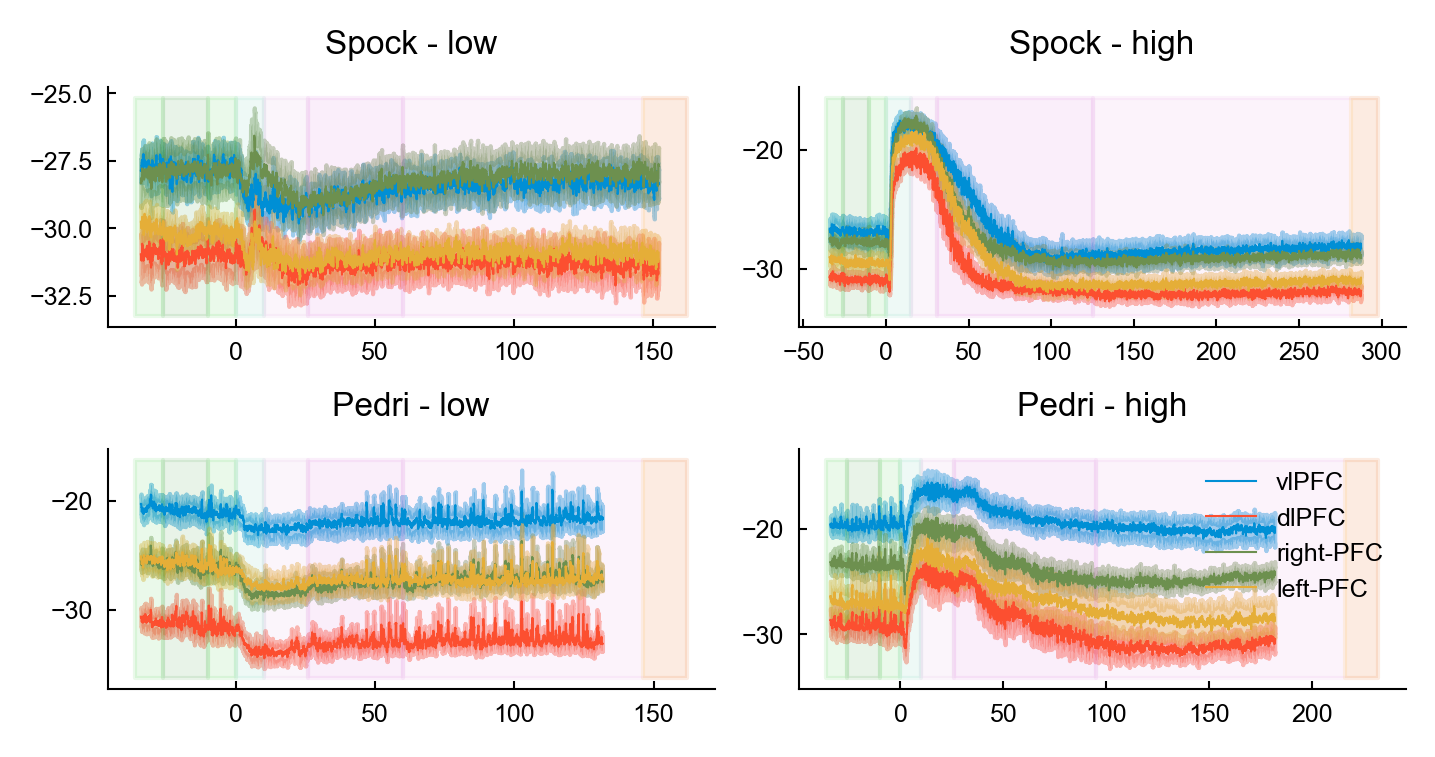

In [37]:
# leadup_time = 18 # minutes before anesthesia
# post_time = 25 # minutes after anesthesia

fig, axs = plt.subplots(2, 2, figsize=(4.7, 2.5045))

lns = []

for i, monkey in enumerate(session_lists.keys()):
    for j, dose in enumerate(session_lists[monkey].keys()):
        ax = axs[i][j]
        for area in stability_all[monkey][dose].keys():

            leadup_time = min([session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
            post_time = min([delase_results[session][area].window_end.max() - session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
            time_vals = np.arange(int((leadup_time + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
            
            plot_start_time = -leadup_time + 2
            plot_end_time = post_time - 10
            time_inds = np.logical_and(time_vals >= plot_start_time, time_vals <= plot_end_time)
            
            # raise ValueError
            mean_vals = stability_all[monkey][dose][area][time_inds].sum(axis=-1)/counts[monkey][dose][area][time_inds].sum(axis=-1)
            std_dev_vals = np.sqrt(np.square(stability_all[monkey][dose][area][time_inds] - np.expand_dims(mean_vals, -1)).sum(axis=-1)/(counts[monkey][dose][area][time_inds].sum(axis=-1) - 1))
            se_vals = std_dev_vals/np.sqrt(counts[monkey][dose][area][time_inds].sum(axis=-1))
            ax.plot(time_vals[time_inds], mean_vals, label=area_labels[area], color=area_colors[area], rasterized=True)
            
            ax.fill_between(time_vals[time_inds], mean_vals - se_vals, mean_vals + se_vals, color=area_colors[area], alpha=0.4, rasterized=True)

            ax.set_title(f"{monkey} - {dose}")

        session = session_lists[monkey][dose][0]
        section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
        ylim= ax.get_ylim()
        for _, (section_name, section_bounds) in enumerate(section_info):
            ax.fill_betweenx(ylim, x1=section_bounds[0], x2=section_bounds[1], color=section_colors[section_name], alpha=0.1)

lns = []
for area in areas:
    lns += plt.plot([], [], label=area_labels[area], color=area_colors[area])
plt.legend(lns, [ln.get_label() for ln in lns])

plt.tight_layout()
plt.show()

In [28]:
monkey = 'Pedri'
dose = 'high'

In [29]:
for session_ind, session in enumerate(session_lists[monkey][dose]):
    leadup_time = min([session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
    post_time = min([delase_results[session][area].window_end.max() - session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
    time_vals = np.arange(int((leadup_time + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
    
    if session_ind == 0:
        break

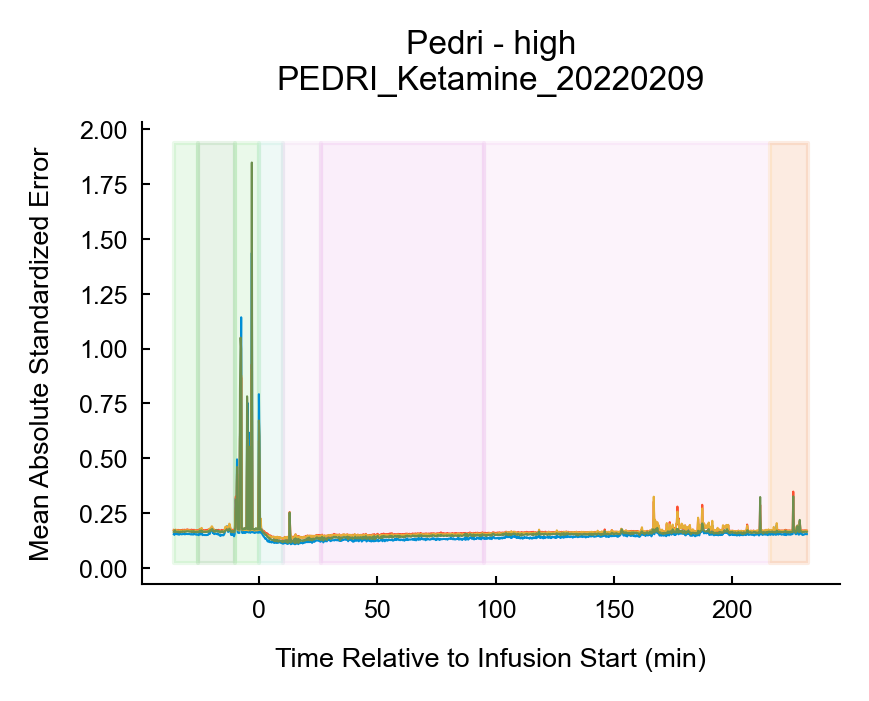

In [34]:
section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)
for area in areas:
    plt.plot(delase_results[session][area].window_start/60 - session_infos[session]['infusionStart']/60, delase_results[session][area].mase_val)
    # plt.plot(delase_results[session][area].window_start/60 - session_infos[session]['infusionStart']/60, delase_results[session][area].mase_val_pb)
    # plt.plot(delase_results[session][area].window_start/60 - session_infos[session]['infusionStart']/60, delase_results[session][area].mase_val_VAR)
ylim= plt.ylim()
for i, (section_name, section_bounds) in enumerate(section_info):
    plt.fill_betweenx(ylim, x1=section_bounds[0], x2=section_bounds[1], color=section_colors[section_name], alpha=0.1)

plt.ylabel('Mean Absolute Standardized Error')
plt.xlabel('Time Relative to Infusion Start (min)')
plt.title(f"{monkey} - {dose}\n{session}")
# plt.plot(delase_results[session][area].mase_val_VAR_small)
plt.show()

In [67]:
directory_path = os.path.join(cfg.params.all_data_dir, cfg.params.data_class, session + '_lfp_chunked_20s', 'directory')
directory = pd.read_pickle(directory_path)

In [68]:
row_max_mase = delase_results[session][area].iloc[delase_results[session][area].mase_val.to_numpy().argmax()]

In [69]:
lfp = load_window_from_chunks(row_max_mase.window_start, row_max_mase.window_end, directory)
lfp_test = load_window_from_chunks(row_max_mase.test_window_start, row_max_mase.test_window_end, directory)

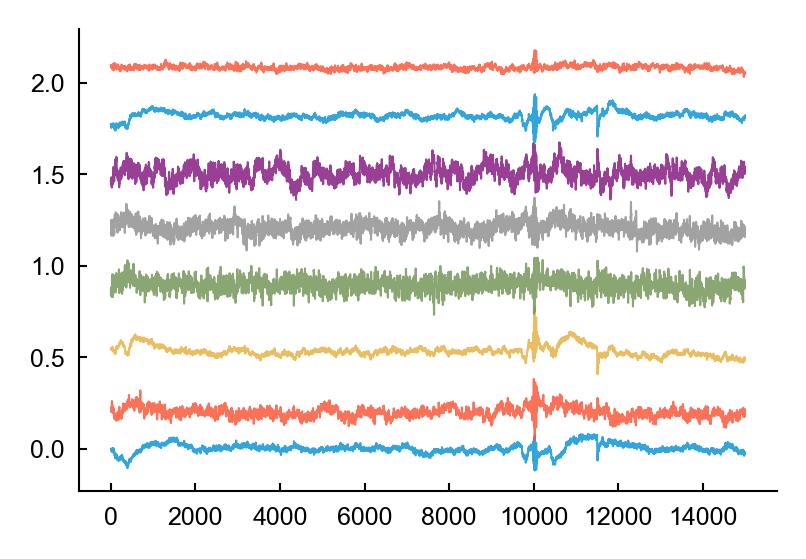

In [70]:
offset = 0
for i in range(0, lfp.shape[1], 16):
    plt.plot(lfp[:, i] + offset, alpha=0.8)
    offset += (lfp[:, i][lfp[:, i] > 0].max() + np.abs(lfp[:, i][lfp[:, i] < 0].min()))
# plt.plot(lfp[:, 0])

In [71]:
session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables=['electrodeInfo'], data_class=cfg.params.data_class, verbose=False)

In [72]:
electrode_info = session_vars['electrodeInfo']

In [73]:
awake_oddball_times = section_info[1][1]
unconscious_oddball_times = section_info[4][1]

In [597]:
len(np.where(['vlPFC' in area for area in electrode_info['area']])[0])

64

In [83]:
np.random.seed(43)
t_a = np.random.uniform(awake_oddball_times[0], awake_oddball_times[1])*60 + session_infos[session]['infusionStart']
t_u = np.random.uniform(unconscious_oddball_times[0], unconscious_oddball_times[1])*60 + session_infos[session]['infusionStart']
# lfp_a = load_window_from_chunks(t_a, t_a + cfg.params.window, directory, dimension_inds=np.where(['vlPFC' in area for area in electrode_info['area']])[0])
# lfp_u = load_window_from_chunks(t_u, t_u + cfg.params.window, directory, dimension_inds=np.where(['vlPFC' in area for area in electrode_info['area']])[0])

window = 30

lfp_a = load_window_from_chunks(t_a, t_a + window, directory)
lfp_u = load_window_from_chunks(t_u, t_u + window, directory)

In [88]:
# n_delays, rank = grid_search_results[session][area]['n_delays'], grid_search_results[session][area]['rank']
n_delays, rank = 10, 850

In [89]:
delase_a = DeLASE(lfp_a, n_delays=n_delays, rank=rank, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, dt=dt, device='cuda')
delase_a.fit()
delase_u = DeLASE(lfp_u, n_delays=n_delays, rank=rank, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, dt=dt, device='cuda')
delase_u.fit()

In [90]:
top_percent = 0.1

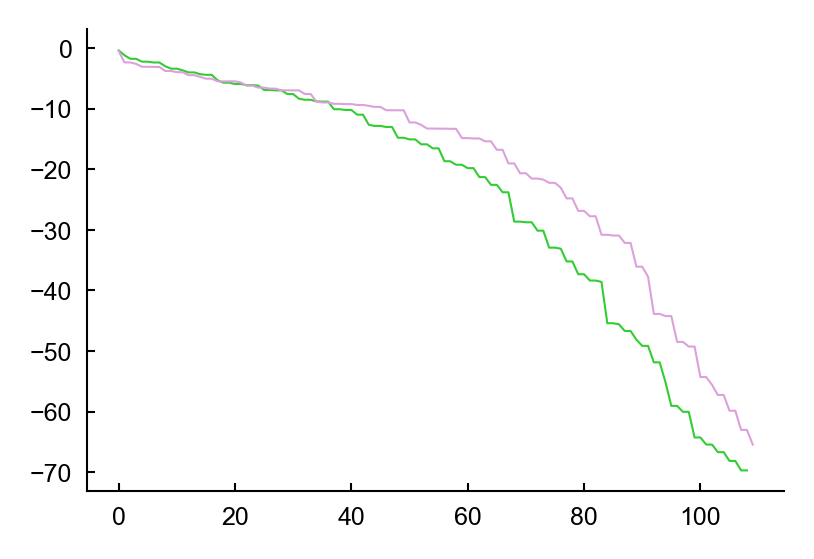

In [91]:
plt.plot(delase_a.stability_params[:int(top_percent*len(delase_a.stability_params))].cpu(), c='limegreen')
plt.plot(delase_u.stability_params[:int(top_percent*len(delase_u.stability_params))].cpu(), c='plum')

In [609]:
# plt.scatter(delase_a.stability_params[:int(top_percent*len(delase_a.stability_params))].cpu(), delase_a.stability_freqs[:int(top_percent*len(delase_a.stability_freqs))].cpu(), s=4, c='limegreen')
# plt.scatter(delase_u.stability_params[:int(top_percent*len(delase_u.stability_params))].cpu(), delase_u.stability_freqs[:int(top_percent*len(delase_u.stability_freqs))].cpu(), s=4, c='plum')
# # plt.scatter(stab_param2[:int(top_percent*len(stab_param1))], stab_freq2[:int(top_percent*len(stab_param1))], s=4)

In [610]:
delase_a.stability_params[:int(top_percent*len(delase_a.stability_params))].cpu().mean(), delase_u.stability_params[:int(top_percent*len(delase_u.stability_params))].cpu().mean()

(tensor(-19.5074), tensor(-19.9633))

In [611]:
mannwhitneyu(delase_a.stability_params[:int(top_percent*len(delase_a.stability_params))].cpu(), delase_u.stability_params[:int(top_percent*len(delase_u.stability_params))].cpu(), alternative='less')

MannwhitneyuResult(statistic=np.float64(3266.0), pvalue=np.float64(0.6941822488196869))

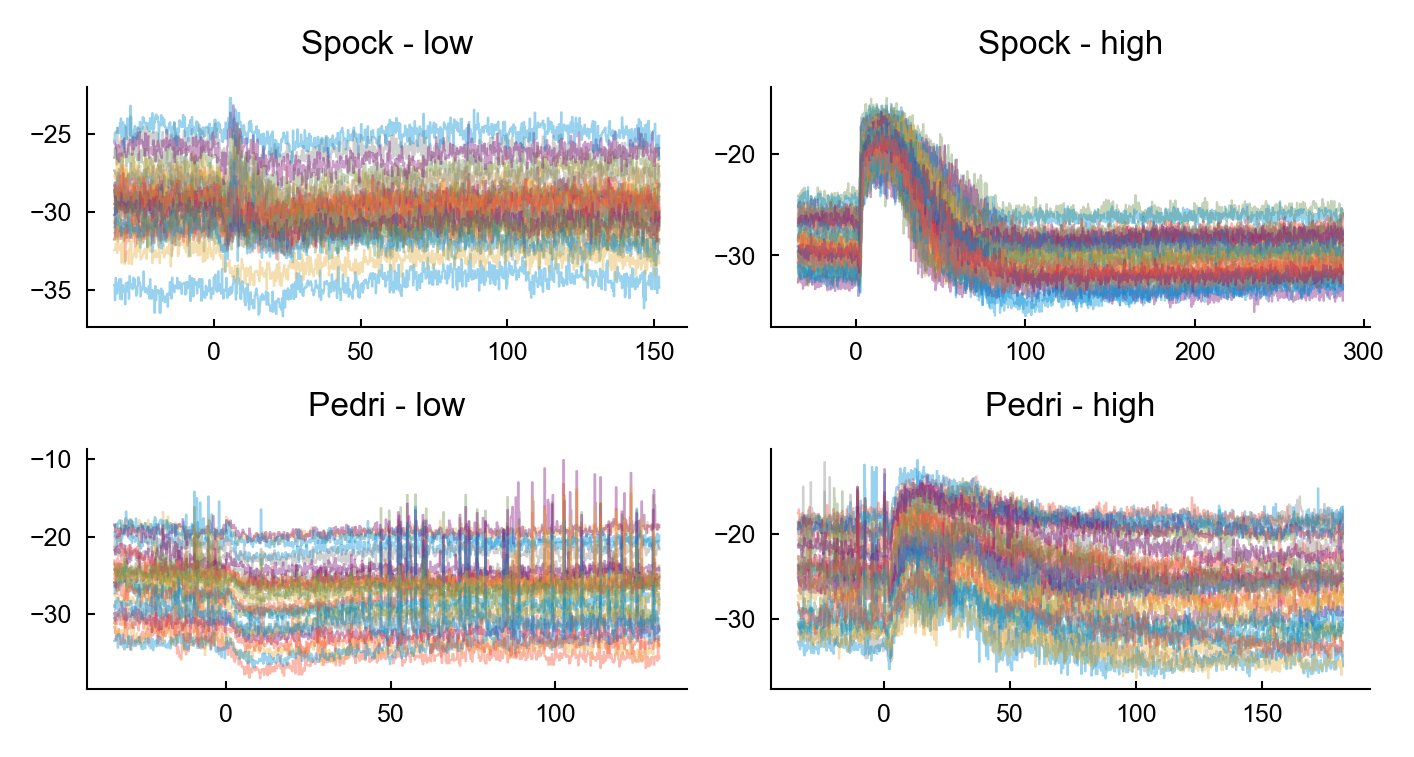

In [38]:
# leadup_time = 18 # minutes before anesthesia
# post_time = 25 # minutes after anesthesia

fig, axs = plt.subplots(2, 2, figsize=(4.7, 2.5045))

lns = []

for i, monkey in enumerate(session_lists.keys()):
    for j, dose in enumerate(session_lists[monkey].keys()):
        ax = axs[i][j]
        for area in stability_all[monkey][dose].keys():

            leadup_time = min([session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60
            post_time = min([delase_results[session][area].window_end.max() - session_infos[session]['infusionStart'] for session in session_lists[monkey][dose]])/60

            time_vals = np.arange(int((leadup_time + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
            plot_start_time = -leadup_time + 2
            plot_end_time = post_time - 10
            time_inds = np.logical_and(time_vals >= plot_start_time, time_vals <= plot_end_time)

            for session_ind in range(stability_all[monkey][dose][area].shape[-1]):
                ax.plot(time_vals[time_inds], stability_all[monkey][dose][area][time_inds, session_ind], label=area_labels[area], rasterized=True, alpha=0.4)

            ax.set_title(f"{monkey} - {dose}")

plt.tight_layout()
plt.show()

In [120]:
for monkey in session_lists.keys():
    for dose in session_lists[monkey].keys():
        print("-"*10)
        print(f"{monkey} - {dose}")
        for session in session_lists[monkey][dose]:
            print((grid_search_results[session][area]['n_delays'], grid_search_results[session][area]['rank']))

----------
Spock - low
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
----------
Spock - high
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
(8, 1000)
----------
Pedri - low
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
----------
Pedri - high
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)
(7, 850)


In [37]:
variables = ['sessionInfo']
session_vars, T, N, dt = load_session_data(session, cfg.params.all_data_dir, variables, data_class=cfg.params.data_class, verbose=False)
session_info = session_vars['sessionInfo']
if 'propofol' in cfg.params.data_class:
    drug_start = session_info['drugStart'][0]
elif 'lever' in cfg.params.data_class:
    drug_start = session_info['infusionStart']

In [38]:
for area in areas:
    break

In [39]:
results_df = delase_results[session][area]

In [40]:
top_percent = 0.1

In [41]:
mean_stab = results_df.stability_params.apply(lambda x: x[:int(len(x)*top_percent)].mean())

In [42]:
time_vals = results_df.window_start/60 - drug_start/60

In [43]:
section_info, section_info_extended, section_colors = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)

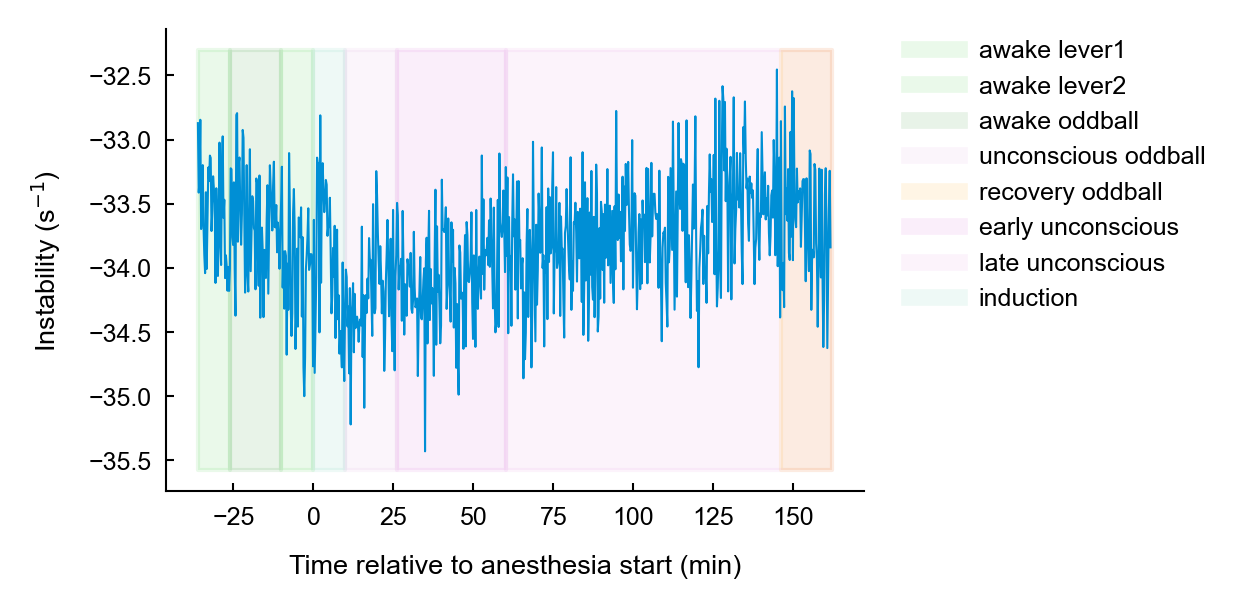

In [44]:
plt.plot(time_vals, mean_stab)
ylim = plt.ylim()

# def adjust_text_positions(section_info, ylim):
#     text_y_pos = []
#     for i, (_, section_bounds) in enumerate(section_info):
#         if i == 0:
#             y_pos = ylim[-1] + (ylim[-1] - ylim[0]) * 0.05
#         else:
#             y_pos = text_y_pos[-1] + (ylim[-1] - ylim[0]) * 0.1
#         text_y_pos.append(y_pos)
#     return text_y_pos

# text_y_pos = adjust_text_positions(section_info, ylim)

# # text_y_pos = np.linspace(ylim[-1] + (ylim[-1] - ylim[0])*0.05, ylim[-1] + (ylim[-1] - ylim[0])*0.2, len(section_info))
for i, (section_name, section_bounds) in enumerate(section_info):
    plt.fill_betweenx(ylim, x1=section_bounds[0], x2=section_bounds[1], color=section_colors[section_name], alpha=0.1)
#     # plt.text(np.mean(section_bounds), ylim[-1] + (ylim[-1] - ylim[0])*0.05, '\n'.join(section_name.split(' ')), color=section_colors[section_name], ha='center', va='center')
#     plt.text(np.mean(section_bounds), text_y_pos[i], '\n'.join(section_name.split(' ')), color=section_colors[section_name], ha='center', va='center')
# plt.xlim([time_vals[0], 180])
plt.xlabel('Time relative to anesthesia start (min)')
plt.ylabel('Instability (s$^{-1}$)')

# Create custom legend handles
legend_handles = [plt.Line2D([0], [0], color=color, lw=4, alpha=0.1) for color in section_colors.values()]
plt.legend(legend_handles, section_colors.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


plt.show()